In [67]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from wishpy.dataworker import DataWorker
dw = DataWorker(google_secret='../../../wishpy/client_secret.json')
import math

# from scipy import stats
from scipy.stats import chi2, chi2_contingency
import statsmodels.stats.api as sms

import ttd_experiment as ttd

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/wishpy/dataworker.py:83: UserWarning: [Errno 2] No such file or directory: '../../../wishpy/client_secret.json'
  warnings.warn(str(e))


## Prepare the data

In [68]:
df = dw.td_query('''
'''
,job_id=740361881
,engine='presto'
                )
df.head()

You can look at job id 740361881


,dimension,dim_value,month_0_user,month_1_user,month_2_user,month_3_user,month_4_user,month_5_user,month_6_user,month_7_user,month_8_user,month_9_user,month_10_user,month_11_user,month_12_user,month_13_plus_user
0,overall_month_country,PR,135679,31804,23829,18966,15136,12284,9964,7513,5441,3841,2448,1243,45,0
1,overall_month_country,LB,326,35,22,13,7,7,6,4,2,1,1,1,0,0
2,overall_month_country,BL,13,5,1,0,2,0,1,0,1,1,0,0,0,0
3,overall_month_country,AF,532,85,66,50,32,28,18,10,10,5,4,1,1,0
4,overall_month_country,PF,573,97,69,42,31,27,20,9,10,1,0,1,0,0


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 16 columns):
dimension             357 non-null object
dim_value             353 non-null object
month_0_user          357 non-null int64
month_1_user          357 non-null int64
month_2_user          357 non-null int64
month_3_user          357 non-null int64
month_4_user          357 non-null int64
month_5_user          357 non-null int64
month_6_user          357 non-null int64
month_7_user          357 non-null int64
month_8_user          357 non-null int64
month_9_user          357 non-null int64
month_10_user         357 non-null int64
month_11_user         357 non-null int64
month_12_user         357 non-null int64
month_13_plus_user    357 non-null int64
dtypes: int64(14), object(2)
memory usage: 44.7+ KB


In [70]:
months = ['month_0_user','month_1_user','month_2_user','month_3_user','month_4_user','month_5_user','month_6_user','month_7_user','month_8_user','month_9_user','month_10_user',
         'month_11_user','month_12_user','month_13_plus_user']
months_p = ['month_0_user_p','month_1_user_p','month_2_user_p','month_3_user_p','month_4_user_p','month_5_user_p','month_6_user_p','month_7_user_p','month_8_user_p','month_9_user_p','month_10_user_p',
         'month_11_user_p','month_12_user_p','month_13_plus_user_p']

# for month, month_p in zip(months,months_p):
#     df[month_p] = df.apply(lambda row: round(100*row[month]/(row['month_0_user']+0.001),2),axis=1)
# df.head(10)

In [71]:
for month, month_p in zip(months,months_p):
    df[month_p] = df.apply(lambda row: round(100*row[month]/(row['month_0_user']+0.001),2),axis=1)
df.head(10)

,dimension,dim_value,month_0_user,month_1_user,month_2_user,month_3_user,month_4_user,month_5_user,month_6_user,month_7_user,...,month_4_user_p,month_5_user_p,month_6_user_p,month_7_user_p,month_8_user_p,month_9_user_p,month_10_user_p,month_11_user_p,month_12_user_p,month_13_plus_user_p
0,overall_month_country,PR,135679,31804,23829,18966,15136,12284,9964,7513,...,11.16,9.05,7.34,5.54,4.01,2.83,1.80,0.92,0.03,0.0
1,overall_month_country,LB,326,35,22,13,7,7,6,4,...,2.15,2.15,1.84,1.23,0.61,0.31,0.31,0.31,0.00,0.0
2,overall_month_country,BL,13,5,1,0,2,0,1,0,...,15.38,0.00,7.69,0.00,7.69,7.69,0.00,0.00,0.00,0.0
3,overall_month_country,AF,532,85,66,50,32,28,18,10,...,6.02,5.26,3.38,1.88,1.88,0.94,0.75,0.19,0.19,0.0
4,overall_month_country,PF,573,97,69,42,31,27,20,9,...,5.41,4.71,3.49,1.57,1.75,0.17,0.00,0.17,0.00,0.0
5,overall_month_country,VU,18,7,2,5,1,1,1,1,...,5.56,5.56,5.56,5.56,0.00,5.56,5.56,0.00,0.00,0.0
6,overall_month_country,GG,416,81,47,41,37,24,13,10,...,8.89,5.77,3.12,2.40,2.40,1.92,0.96,0.72,0.00,0.0
7,overall_month_country,HM,4,0,0,0,1,0,0,1,...,24.99,0.00,0.00,24.99,0.00,0.00,0.00,0.00,0.00,0.0
8,overall_month_country,BR,4768459,735261,622786,463577,331520,239236,168329,112766,...,6.95,5.02,3.53,2.36,1.45,0.83,0.41,0.16,0.00,0.0
9,overall_month_country,GN,25,4,3,3,1,0,1,0,...,4.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


## Plot of retention

### overall retention plot

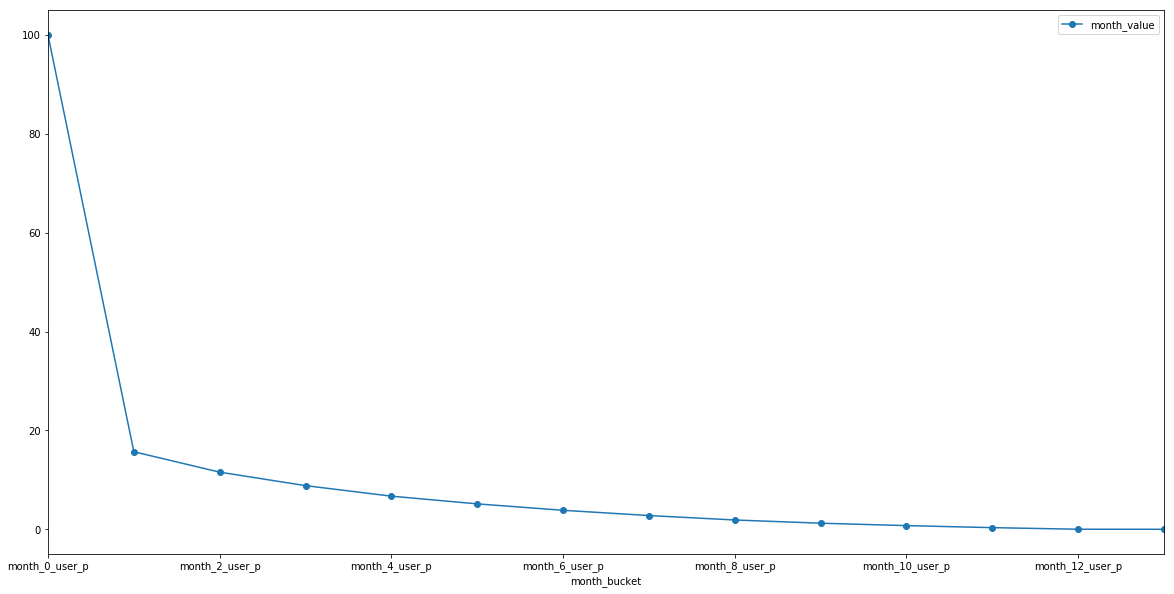

In [78]:
df_overall_month = df.loc[df.dimension=='overall_month',].melt(id_vars=['dimension','dim_value'], 
                                                               value_vars=months_p,
                                                               var_name='month_bucket', value_name='month_value').sort_values(by='month_value',ascending=False).set_index('month_bucket')
df_overall_month 
df_overall_month.plot(y='month_value',figsize=(20, 10),linestyle='-', marker='o')

### All possible dim/cut

In [79]:
list(set(df.dimension))

['overall_month_gender',
 'overall_month_min_ttd_shown_mean_bucket',
 'overall_month_min_ttd_shown_max_bucket',
 'overall_month_value',
 'overall_month_late_ttd_diff_mean_bucket',
 'overall_month_late_delivery_perc_bucket',
 'overall_month_ttd_mean_bucket',
 'overall_month_logistics_o_overall_refund_bucket',
 'overall_month_ttd_max_bucket',
 'overall_month_domain',
 'overall_month_ttd_min_bucket',
 'overall_month_max_ttd_shown_max_bucket',
 'overall_month_age',
 'overall_month_max_ttd_shown_mean_bucket',
 'overall_month_has_refund',
 'overall_month',
 'overall_month_llr_bucket',
 'overall_month_country']

In [103]:
def retention_dim_plot(df,dim_name):
    months_p = ['month_0_user_p','month_1_user_p','month_2_user_p','month_3_user_p','month_4_user_p','month_5_user_p','month_6_user_p','month_7_user_p','month_8_user_p','month_9_user_p','month_10_user_p',
         'month_11_user_p','month_12_user_p','month_13_plus_user_p']

    df_dim = df.loc[df.dimension==dim_name,].melt(id_vars=['dimension','dim_value'], 
                                                               value_vars=months_p,
                                                               var_name='month_bucket', value_name='month_value').\
                                                               sort_values(by='month_value',ascending=False).set_index('month_bucket')
    x=list(set(df_dim['dim_value']))
    
    df_dim_2 = df_dim.pivot_table(columns='dim_value', values='month_value', index='month_bucket').\
                        sort_values(by=x[1],ascending=False)
    
    df_dim_2.plot(figsize=(20, 10),linestyle='-', marker='o',title='monthly retention chart, by dim - {}'.format(dim_name))

### overall_month_age 

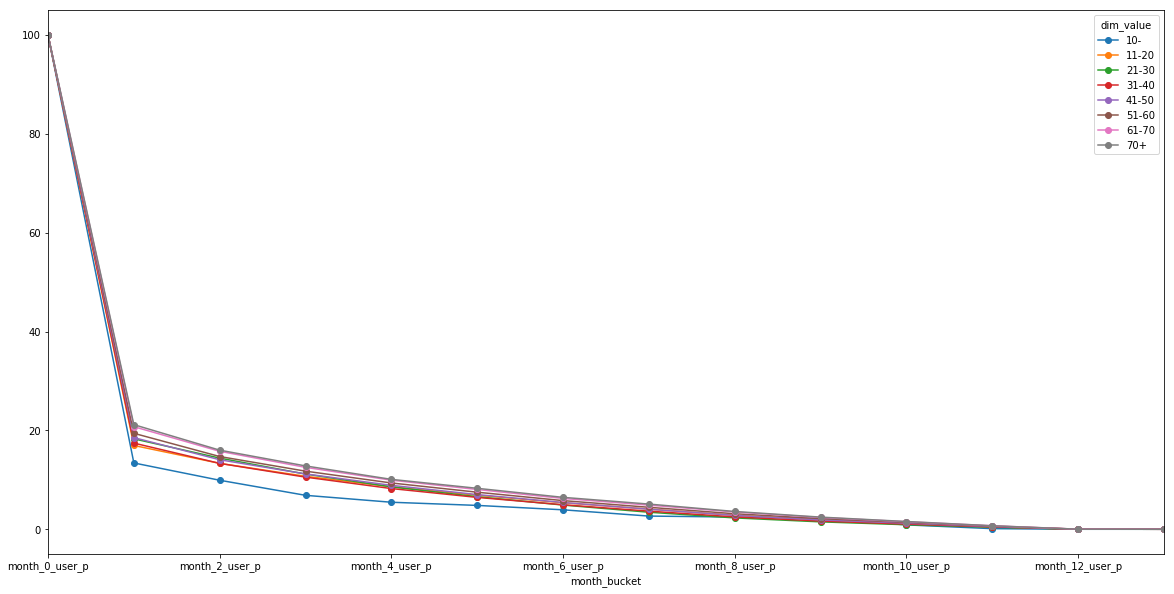

In [87]:
retention_dim_plot(df,'overall_month_age')

### overall_month_gender

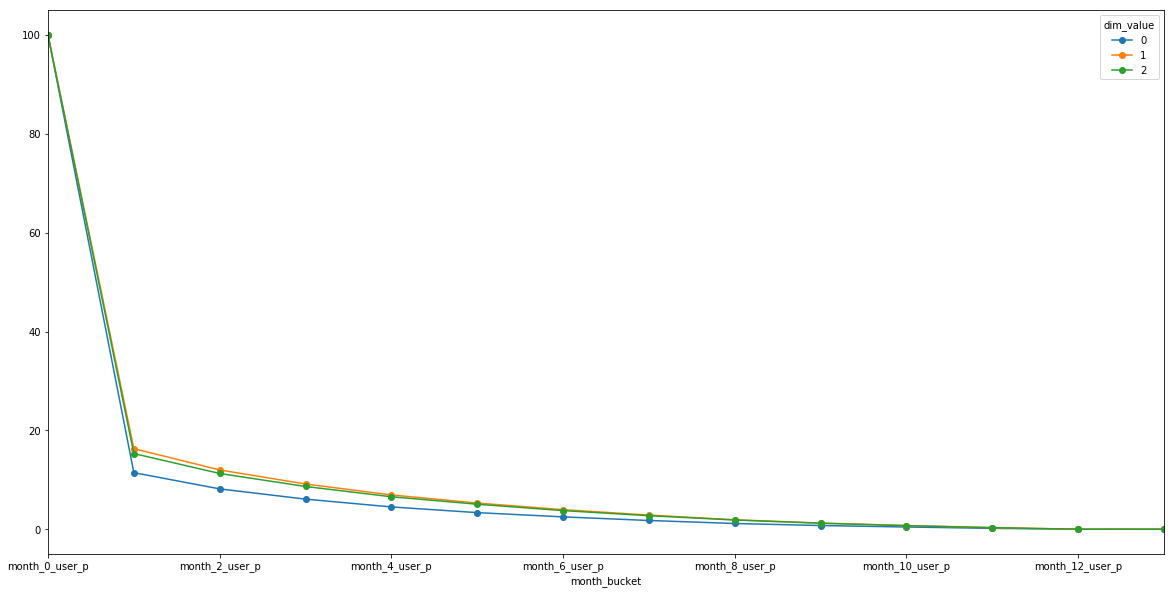

In [88]:
retention_dim_plot(df,'overall_month_gender')

### has ever refund

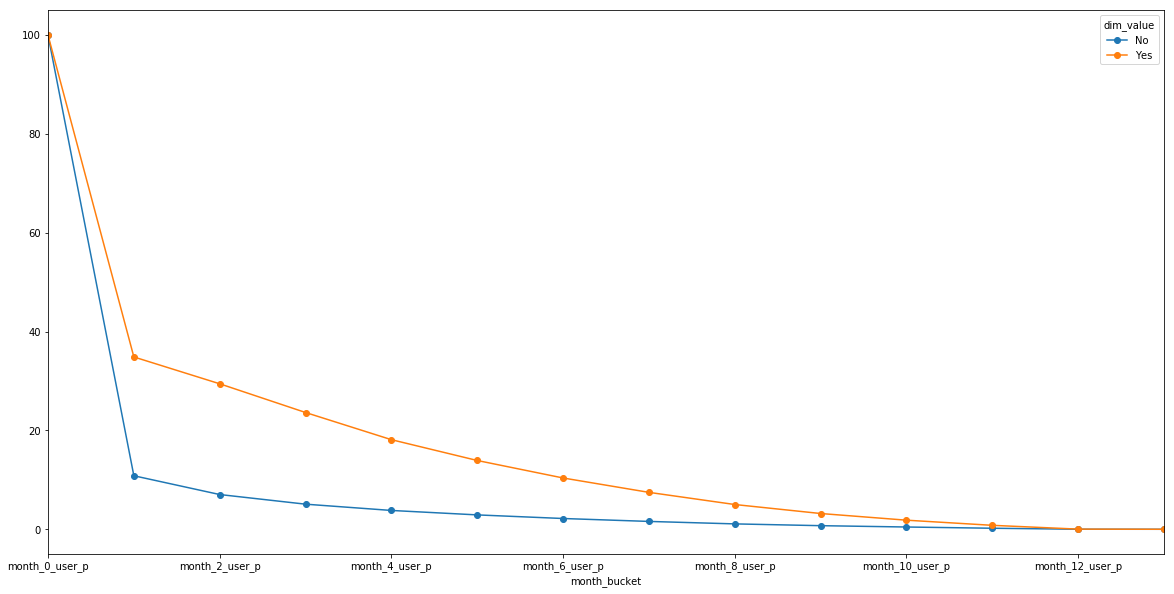

In [89]:
retention_dim_plot(df,'overall_month_has_refund')

### avg_value_bucket


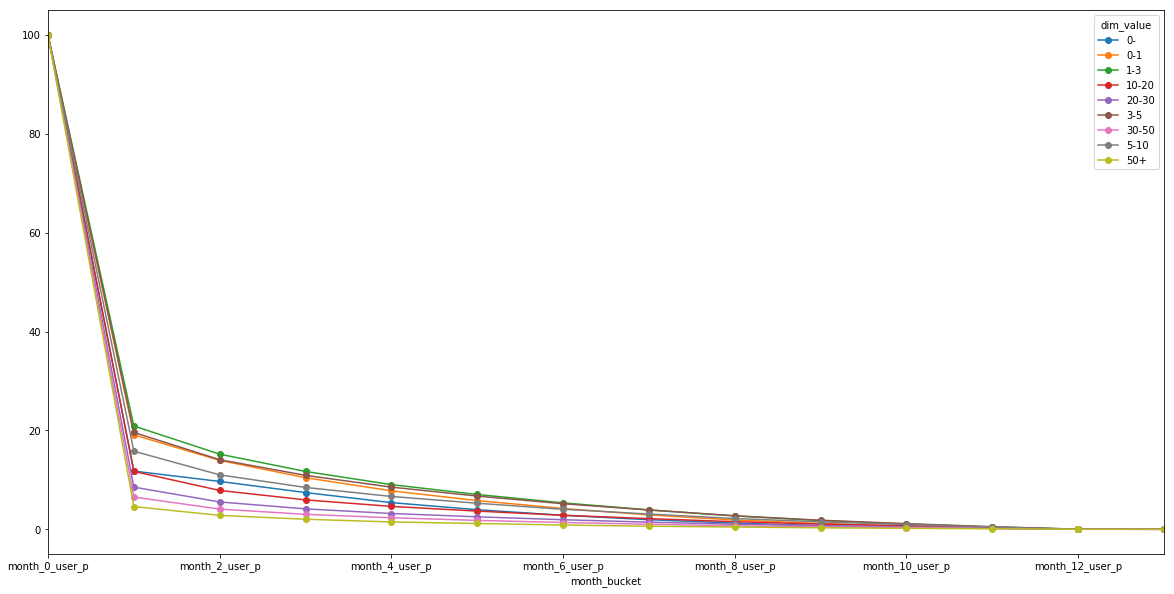

In [90]:
retention_dim_plot(df,'overall_month_value')

### dim on overall_month_domain

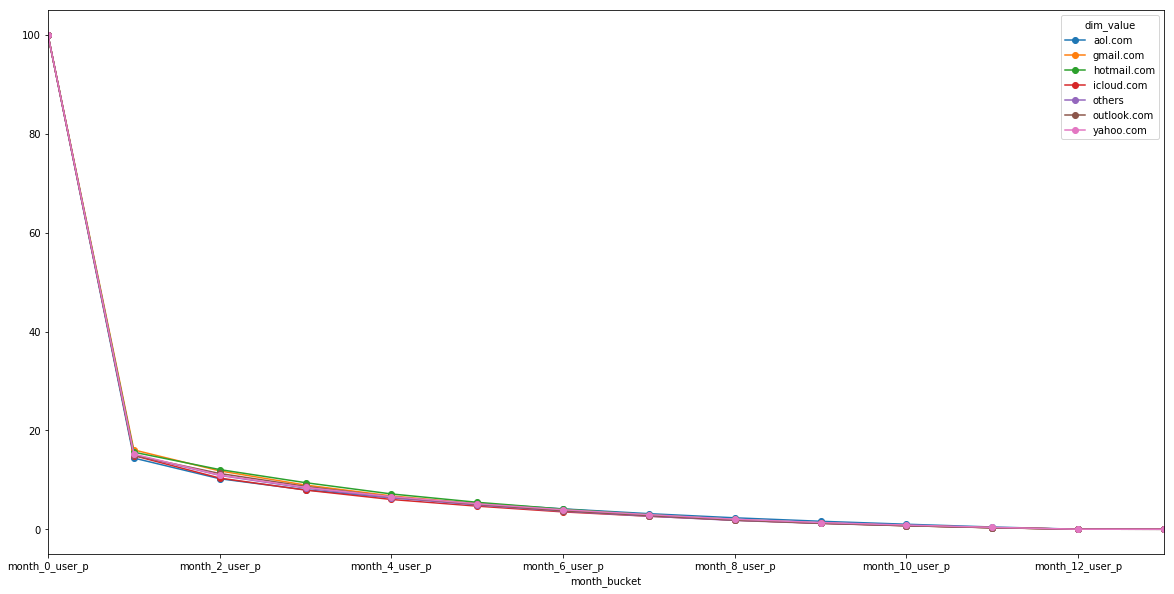

In [92]:
retention_dim_plot(df,'overall_month_domain')

### Top 6 countries

In [96]:
mask = df['dim_value'].isin(['US', 'DE', 'GB', 'FR', 'BR', 'AU'])
# mask

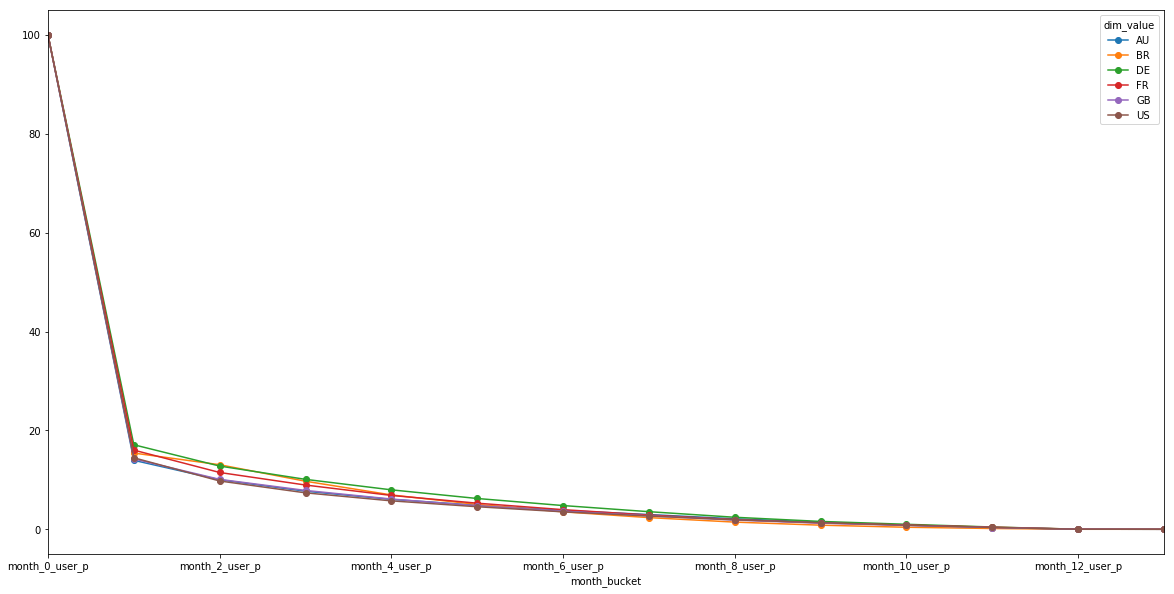

In [98]:
retention_dim_plot(df.loc[mask,:],'overall_month_country')

### retention on TTD

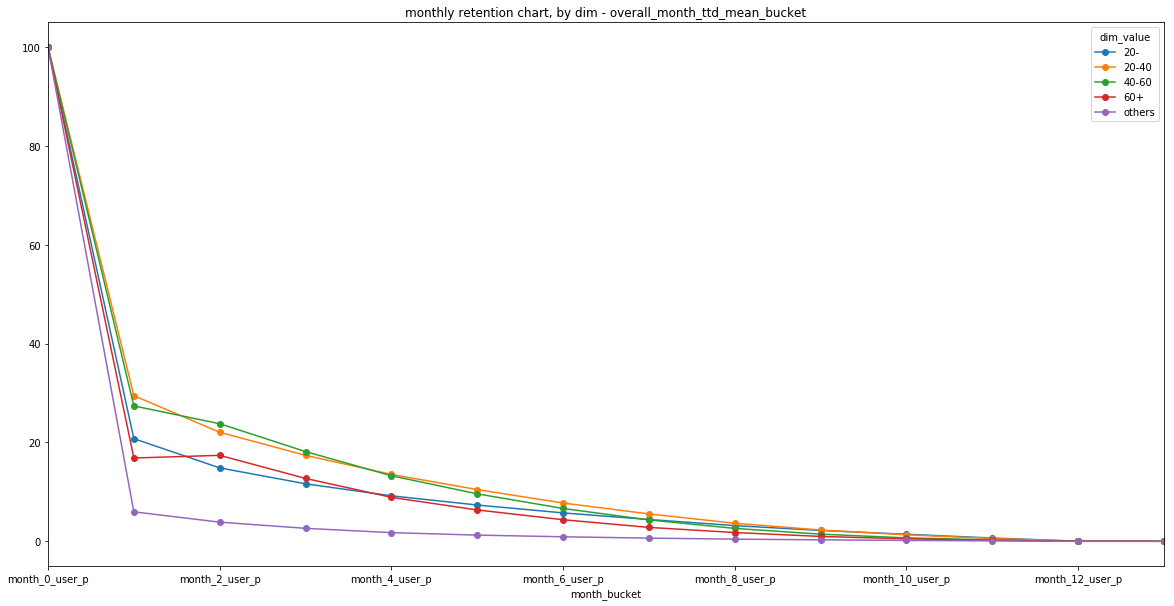

In [104]:
retention_dim_plot(df,'overall_month_ttd_mean_bucket')

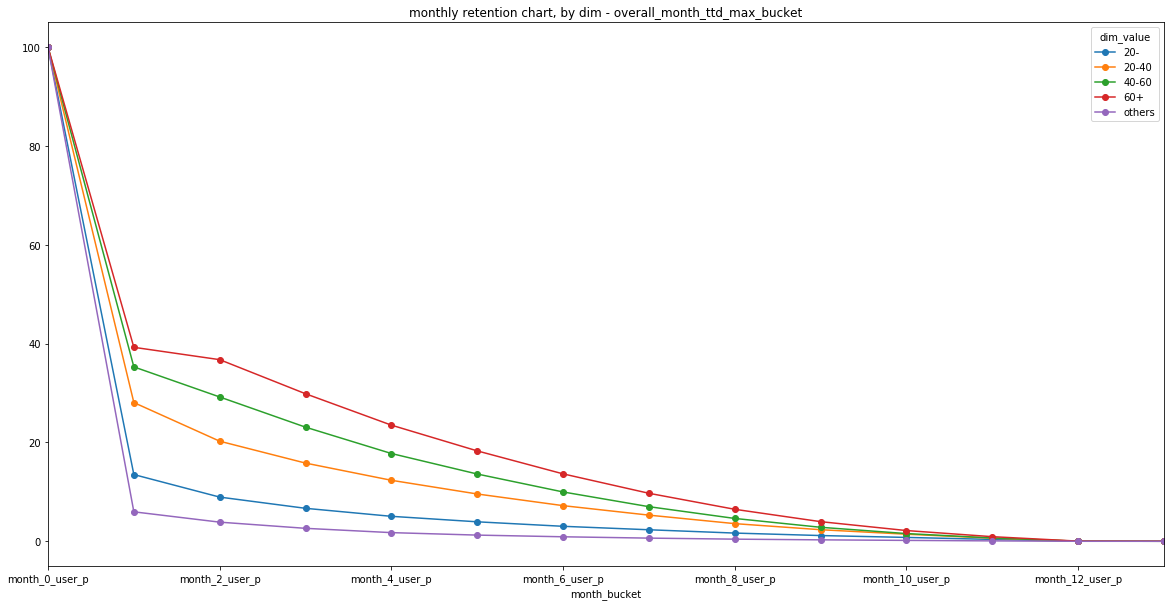

In [105]:
retention_dim_plot(df,'overall_month_ttd_max_bucket')

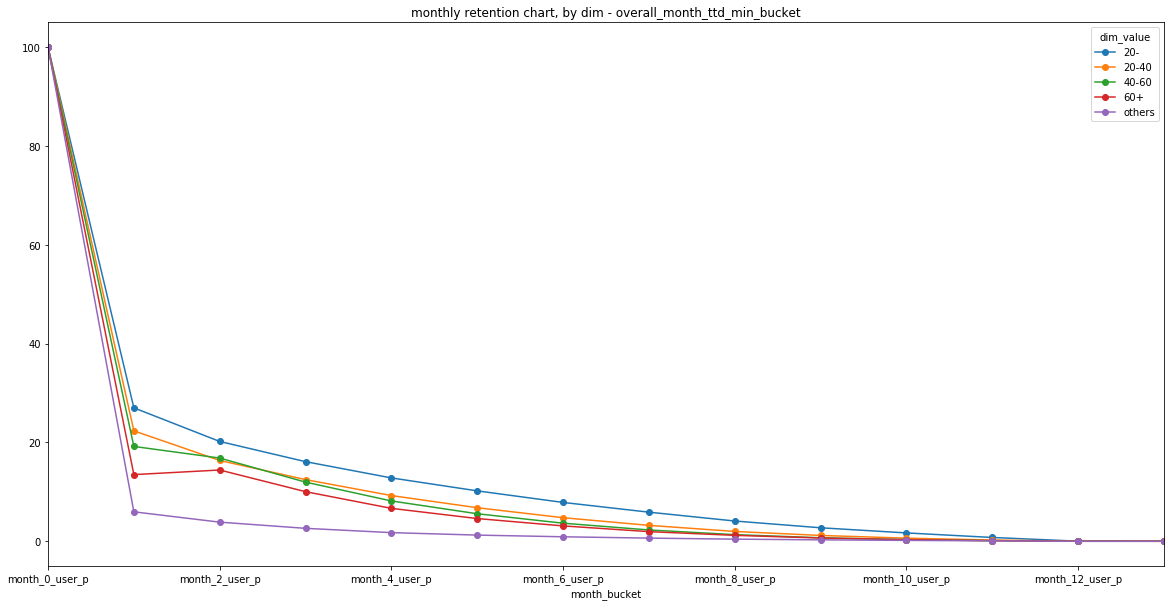

In [108]:
retention_dim_plot(df,'overall_month_ttd_min_bucket')

In [110]:
sorted(set(df.dimension))

['overall_month',
 'overall_month_age',
 'overall_month_country',
 'overall_month_domain',
 'overall_month_gender',
 'overall_month_has_refund',
 'overall_month_late_delivery_perc_bucket',
 'overall_month_late_ttd_diff_mean_bucket',
 'overall_month_llr_bucket',
 'overall_month_logistics_o_overall_refund_bucket',
 'overall_month_max_ttd_shown_max_bucket',
 'overall_month_max_ttd_shown_mean_bucket',
 'overall_month_min_ttd_shown_max_bucket',
 'overall_month_min_ttd_shown_mean_bucket',
 'overall_month_ttd_max_bucket',
 'overall_month_ttd_mean_bucket',
 'overall_month_ttd_min_bucket',
 'overall_month_value']

### on refund rate related

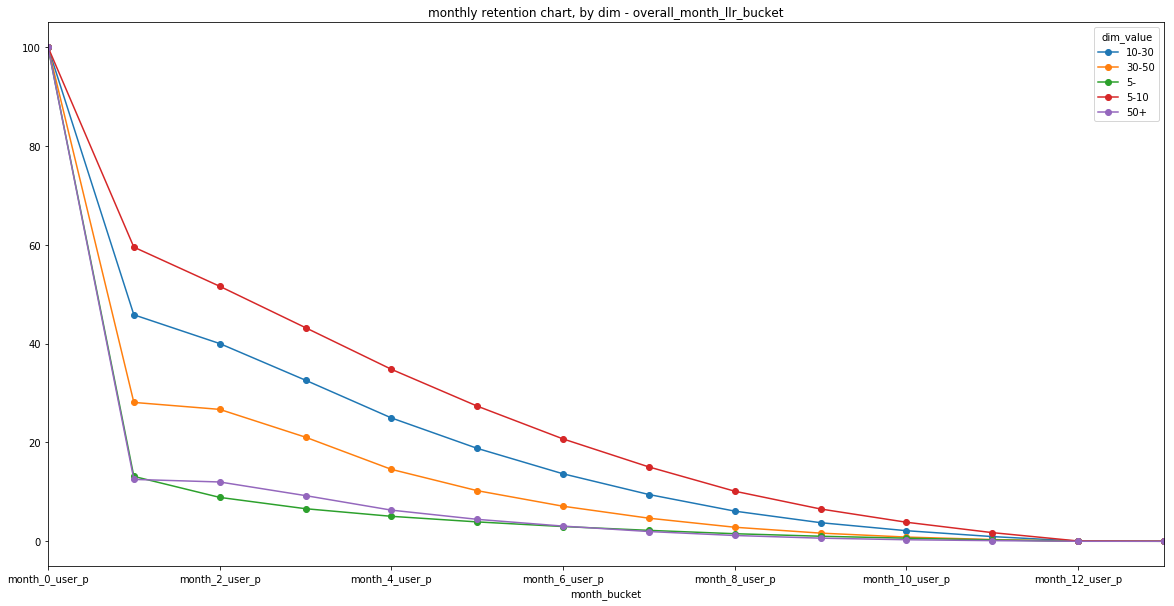

In [111]:
retention_dim_plot(df,'overall_month_llr_bucket')

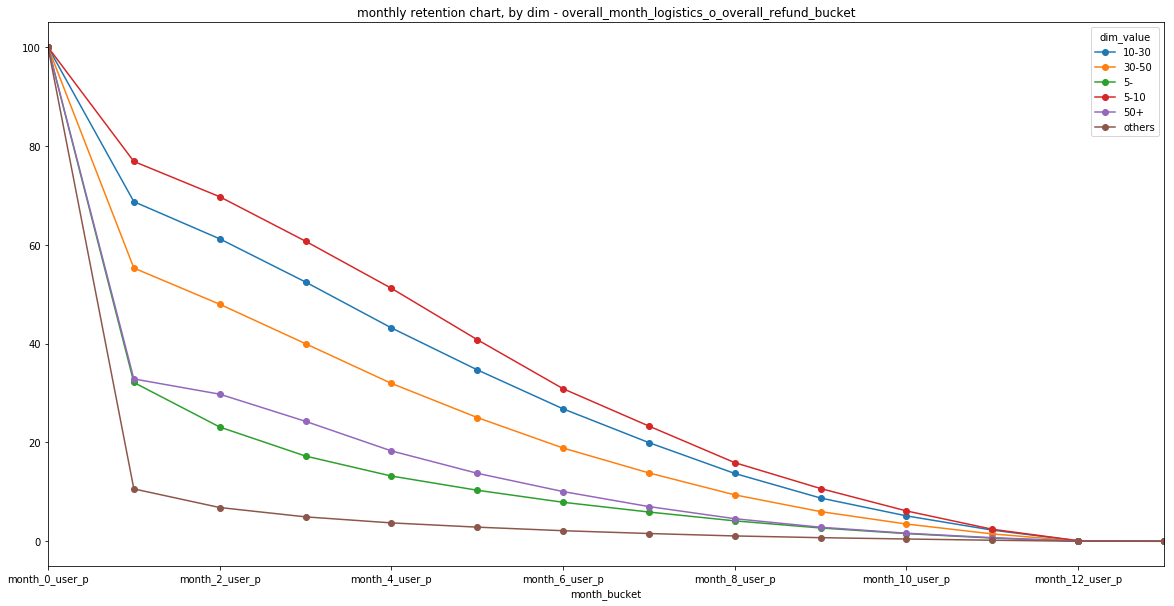

In [112]:
retention_dim_plot(df,'overall_month_logistics_o_overall_refund_bucket')

### late delivery performance


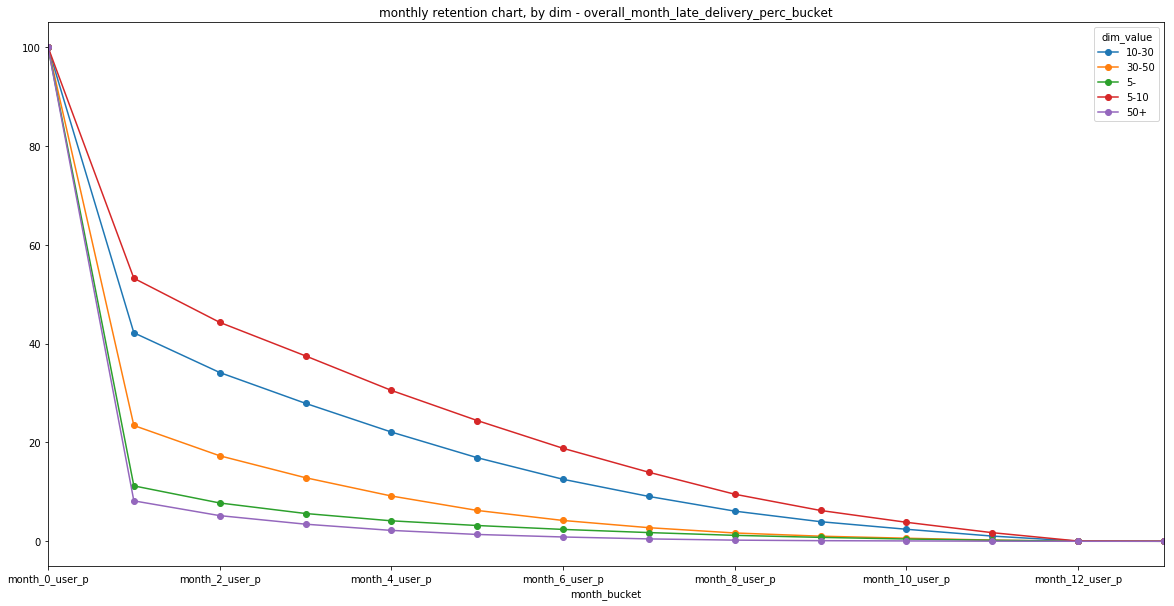

In [113]:
retention_dim_plot(df,'overall_month_late_delivery_perc_bucket')

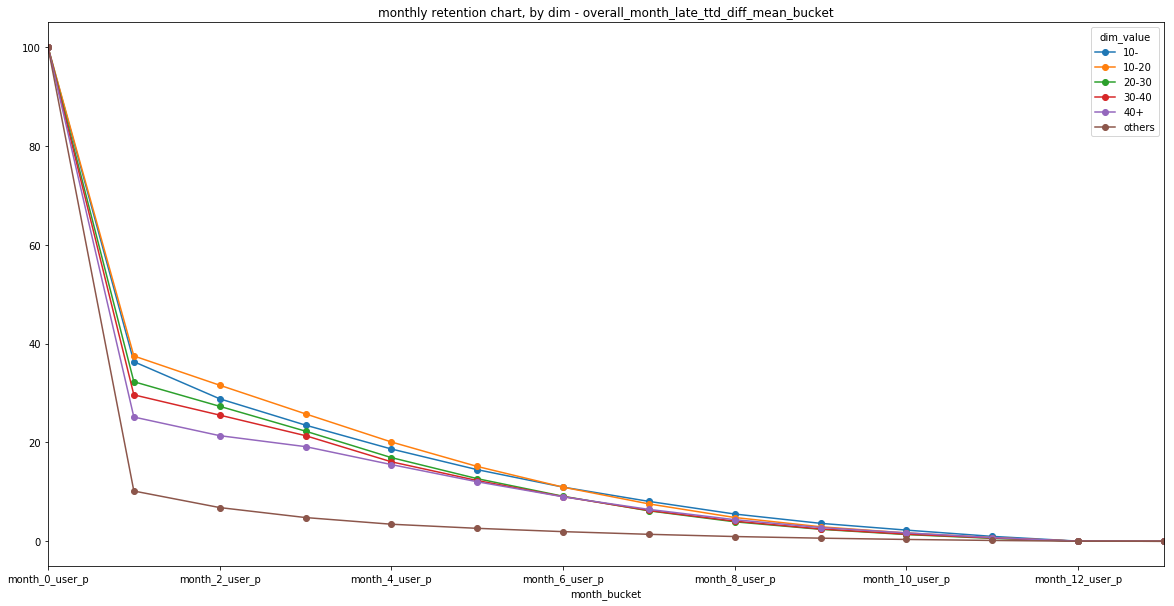

In [114]:
retention_dim_plot(df,'overall_month_late_ttd_diff_mean_bucket')

In [115]:
sorted(set(df.dimension))

['overall_month',
 'overall_month_age',
 'overall_month_country',
 'overall_month_domain',
 'overall_month_gender',
 'overall_month_has_refund',
 'overall_month_late_delivery_perc_bucket',
 'overall_month_late_ttd_diff_mean_bucket',
 'overall_month_llr_bucket',
 'overall_month_logistics_o_overall_refund_bucket',
 'overall_month_max_ttd_shown_max_bucket',
 'overall_month_max_ttd_shown_mean_bucket',
 'overall_month_min_ttd_shown_max_bucket',
 'overall_month_min_ttd_shown_mean_bucket',
 'overall_month_ttd_max_bucket',
 'overall_month_ttd_mean_bucket',
 'overall_month_ttd_min_bucket',
 'overall_month_value']

### on max_ttd_shown

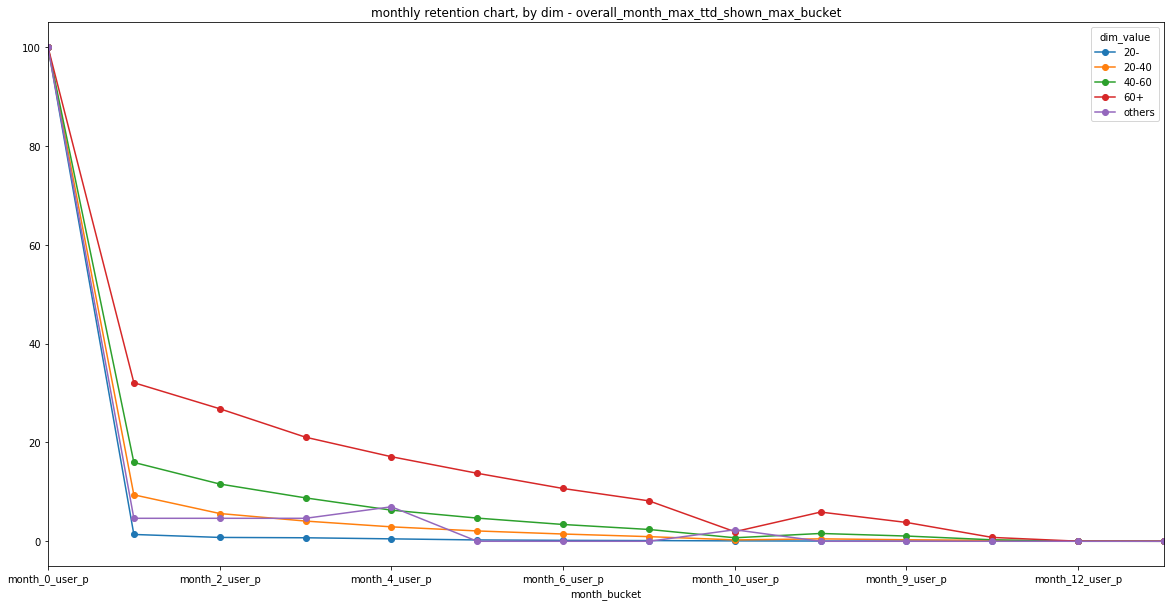

In [116]:
retention_dim_plot(df,'overall_month_max_ttd_shown_max_bucket')

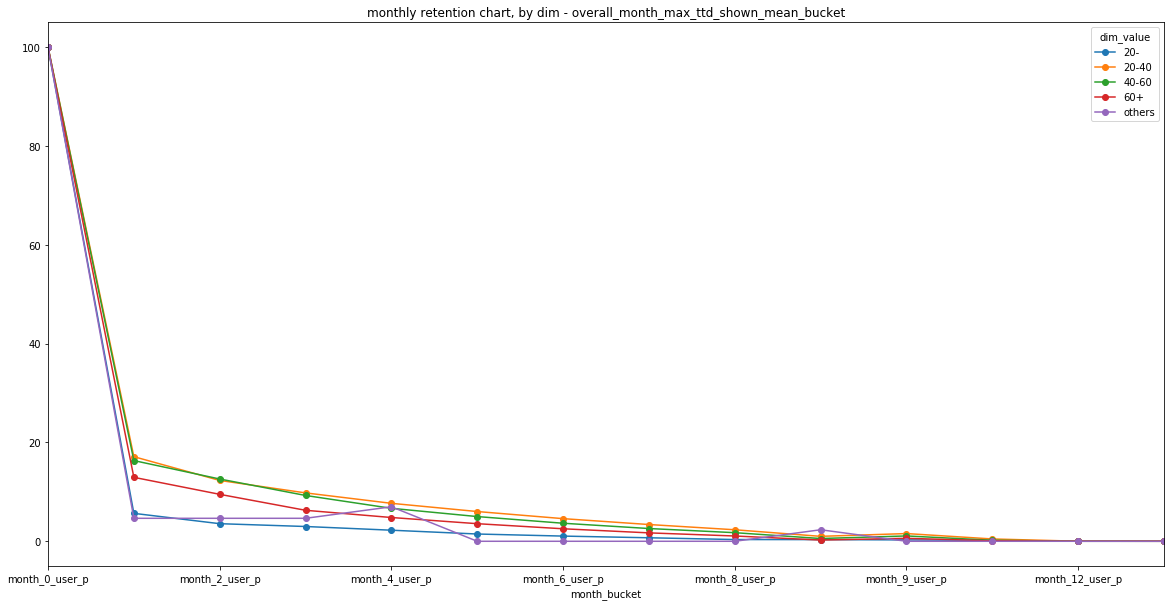

In [117]:
retention_dim_plot(df,'overall_month_max_ttd_shown_mean_bucket')

### on min_ttd_shown

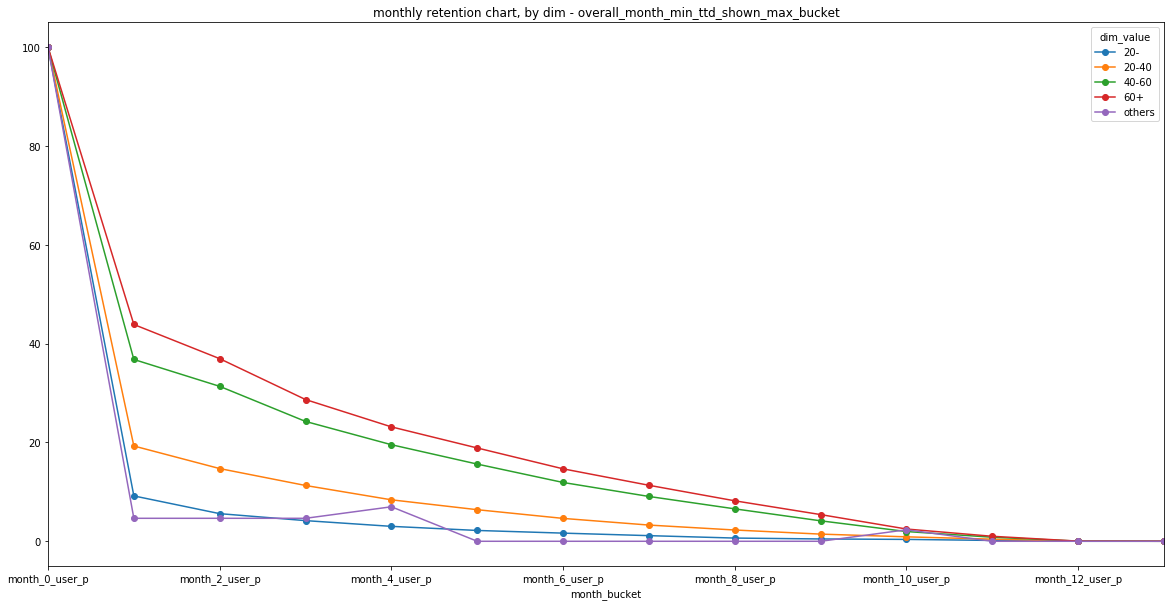

In [118]:
retention_dim_plot(df,'overall_month_min_ttd_shown_max_bucket')

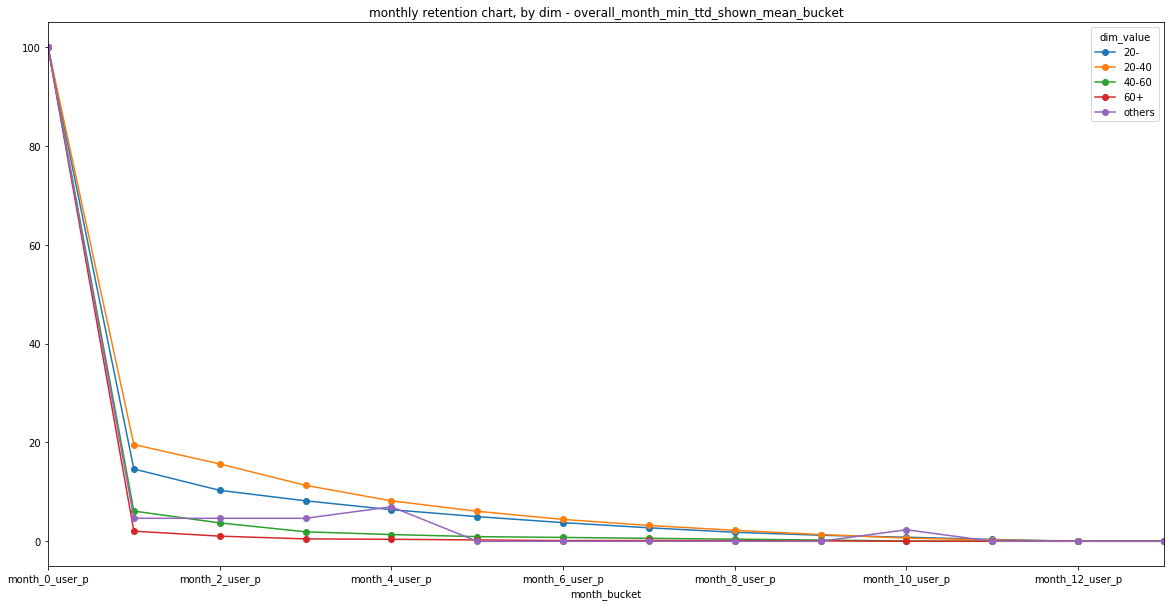

In [119]:
retention_dim_plot(df,'overall_month_min_ttd_shown_mean_bucket')